## Optimal controller -- maximum possible performance

This notebook uses Alice's matching code to determine the maximum possible performance

Inputs:

1. a picked peak file, with the peak *boundaries*
1. the length of time an MS1 scan takes
1. the length of time an MS2 scan takes
1. N (for top-N)
1. the minimum intensity for fragmentation

The code then creates a bipartite graph with two types of nodes:

1. scans (of either MS1 or MS2)
1. peaks

An edge is added between a scan and a peak *iff*:

1. the scan start time is within the start and end RT of the peak
1. the peak had an intensity >= the min intensity at the time of the last MS1 scan

i.e. this is showing the best possible top-N performance if, by magic, one could not fragment anything that didn't turn into a peak.

In [122]:
import sys
import bisect

import networkx as nx
import numpy as np

import pylab as plt
%matplotlib inline

In [31]:
vimms_folder = '/home/simon/git/vimms/'

In [32]:
sys.path.append(vimms_folder)

Local package import

In [33]:
from mass_spec_utils.data_import.mzml import MZMLFile
from mass_spec_utils.data_import.mzmine import load_picked_boxes
from vimms.Roi import Roi

## Define parameters

In [160]:
min_rt = 0 # start value
max_rt = 26*60 # end value
N = 10 # top-N value
min_ms1_intensity = 5e3 # min intensity for fragmentation

mix = 'QCA'

data_path = '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Experimental_Results/20200717_TopN_vs_ROI_rerun/'

pp_file_path = os.path.join(data_path,mix,'Fullscan_{}_box.csv'.format(mix))
mzml_file_path = os.path.join(data_path,mix,'Fullscan_{}.mzML'.format(mix))
verbose = True



### 1. Load the picked peak boxes

In [161]:
boxes = load_picked_boxes(pp_file_path)
print("Loaded {} picked peak boxes".format(len(boxes)))

Loaded 4481 picked peak boxes


### 2. Load the mzml file

In [162]:
mzfile  = MZMLFile(mzml_file_path)

Loaded 3351 scans


### 2a. Extract timings from mzML files

In [190]:
timing_file = os.path.join(data_path,mix,'TopN_{}.mzML'.format(mix))


In [191]:
def get_times(mzfile_object):
    times = {1: [], 2:[]}
    for i,scan in enumerate(mzfile_object.scans[1:]):
        scan_level = mzfile_object.scans[i].ms_level
        elapsed_time = scan.rt_in_seconds  - mzfile_object.scans[i].rt_in_seconds
        if elapsed_time > 0:
            times[scan_level].append(elapsed_time)
    return times


times = get_times(MZMLFile(timing_file))
print(np.array(times[1]).mean())
print(np.array(times[2]).mean())


Loaded 6570 scans
0.6354254450181306
0.19914910611384426


In [192]:
topn_time_dict = {}
for s,t in times.items():
    topn_time_dict[s] = np.array(t).mean()

### 3. Set up the scan times

In [193]:
scan_levels = []
scan_start_times = []
time = 0
while True:
    # add an MS1
    scan_levels.append(1)
    scan_start_times.append(time)
    time += topn_time_dict[1]
    if time > max_rt:
        break
    # add N MS2
    for n in range(N):
        scan_levels.append(2)
        scan_start_times.append(time)
        time += topn_time_dict[2]
        if time > max_rt:
            break
print("Created {} scan times and levels".format(len(scan_levels)))

Created 6534 scan times and levels


### 4. Add ROIs to the peak boxes

In [194]:
# reset in case we run more than once
for box in boxes:
    box.roi = None
    
for i,scan in enumerate(mzfile.scans):
    if scan.ms_level == 2:
        continue # skip MS2 scans
    if verbose and i%100 == 0:
        print(i,len(mzfile.scans))
        
    scan_rt = scan.rt_in_seconds
    
    # find the boxes that are active at this scan
    ok_boxes = list(filter(lambda x: x.rt_range_in_seconds[0] <= scan_rt and x.rt_range_in_seconds[1] >= scan_rt,boxes))
    if len(ok_boxes) == 0:
        continue # no boxes now, onto the next scan
    
    mz_list,intensity_list = zip(*scan.peaks)
    for box in ok_boxes:
        
        min_idx = bisect.bisect_right(mz_list,box.mz_range[0])
        max_idx = bisect.bisect_right(mz_list,box.mz_range[1])
        sub_peaks = []
        for i in range(min_idx,max_idx):
            sub_peaks.append((mz_list[i],intensity_list[i]))
        if len(sub_peaks) > 0:
            sub_peaks.sort(key = lambda x: x[1],reverse = True) # sort by descending intensity
            peak_mz = sub_peaks[0][0]
            peak_intensity = sub_peaks[0][1]
            peak_rt = scan_rt

            if box.roi is None:
                box.roi = Roi(peak_mz,peak_rt,peak_intensity)
            else:
                box.roi.add(peak_mz,peak_rt,peak_intensity)
                
n_with_roi = 0
for box in boxes:
    if box.roi is not None:
        n_with_roi += 1
print("Of {} boxes, {} have roi".format(len(boxes),n_with_roi))

0 3351
100 3351
200 3351
300 3351
400 3351
500 3351
600 3351
700 3351
800 3351
900 3351
1000 3351
1100 3351
1200 3351
1300 3351
1400 3351
1500 3351
1600 3351
1700 3351
1800 3351
1900 3351
2000 3351
2100 3351
2200 3351
2300 3351
2400 3351
2500 3351
2600 3351
2700 3351
2800 3351
2900 3351
3000 3351
3100 3351
3200 3351
3300 3351
Of 4481 boxes, 4481 have roi


### 5. Make the graph edges

1. Loop over the boxes
1. Find all MS1 scans at which the intensity exceeds the minmum
1. Add edges to all ms2 scans within the block

Note:
 - This method ignores the intensity *at the MS2 scan time*


In [195]:
def get_intensity(roi,rt,interpolate = False):
    if rt < roi.rt_list[0] or rt > roi.rt_list[-1]:
        return 0
    else:
        pos = bisect.bisect_right(roi.rt_list,rt)
        before_pos = pos - 1
        after_pos = pos
        if interpolate:
            prop = (rt - roi.rt_list[before_pos])/(roi.rt_list[after_pos] - roi.rt_list[before_pos])
            return roi.intensity_list[before_pos] + prop*(roi.intensity_list[after_pos] - roi.intensity_list[before_pos])
        else:
            return roi.intensity_list[before_pos]

edges = []

for box in boxes:
    peak_id = box.peak_id
    rt_start = box.rt_range_in_seconds[0]
    rt_end = box.rt_range_in_seconds[1]
    spo = bisect.bisect_right(scan_start_times,rt_start)
    can_fragment = False # until we see an MS1
    while spo < len(scan_start_times) and scan_start_times[spo] < rt_end:
        if scan_levels[spo] == 1:
            if get_intensity(box.roi,scan_start_times[spo]) >= min_ms1_intensity:
                can_fragment = True
            else:
                can_fragment = False
        if scan_levels[spo] == 2:
            if can_fragment:
                edges.append(("S{}".format(spo),"B{}".format(peak_id),box))
        spo += 1
print("{} possible edges found".format(len(edges)))

210205 possible edges found


In [196]:
scan_names,box_names,_ = zip(*edges)
scanSet = set(scan_names)
boxSet = set(box_names)
reduced_edges = list(zip(scan_names,box_names))

In [197]:

def reducedUnweightedMaxMatchingFromLists(scanSet,boxSet,edgeList):
    G = nx.Graph() #create an empty graph
    G.add_nodes_from(scanSet, bipartite=0) #add both lists of vertices as nodes to graph
    G.add_nodes_from(boxSet, bipartite=1)
    G.add_edges_from(edgeList) # add edges to graph from list
    print('There are {} scans and {} boxes'.format(len(scanSet),len(boxSet)))
    print('There are {} edges in total'.format(len(edgeList)))
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0} #scans
    matching  = nx.bipartite.matching.hopcroft_karp_matching(G,top_nodes) #call the matching algorithms
    size = 0
    scanList = list(scanSet)
    matchList = [(s,'-') for s in scanList]

    items_list = list(matching.items())[:len(matching)//2]

    for scan,box in items_list:
        ind = scanList.index(scan) 
        matchList[ind] = (scan, box) #update entry in the matchList
        size=size+1

    return matchList,size



In [198]:
matchList,size = reducedUnweightedMaxMatchingFromLists(scanSet,boxSet,reduced_edges)
print(size)

There are 5892 scans and 2266 boxes
There are 210205 edges in total
1767


## Old stuff

In [297]:
print(edges[:10])
edges.sort()
print(edges[:10])

[(2168, 376), (2169, 376), (2170, 376), (2171, 376), (2172, 376), (2173, 376), (2174, 376), (2175, 376), (2176, 376), (2177, 376)]
[(133, 177), (133, 1114), (133, 1745), (133, 3935), (134, 177), (134, 1114), (134, 1745), (134, 3935), (135, 177), (135, 1114)]


In [298]:
import csv
orig_edges = []
with open('/home/simon/git/vimms/experimental/graph_optimal/qca_5e3_edges.csv','w') as f:
    writer = csv.writer(f)
    for scan,peak in edges:
        writer.writerow(['S{}'.format(scan),'B{}'.format(peak)])
        orig_edges.append(['B{}'.format(peak),'S{}'.format(scan)])

In [94]:
edges = set(edges)

In [95]:
print(len(edges))

769853


Check the initial results

In [303]:
res_file = '/home/simon/git/vimms/experimental/graph_optimal/qcb_edgesResults.txt'
matches = []
with open(res_file,'r') as f:
    reader = csv.reader(f,delimiter = ',')
    for line in reader:
        if len(line) < 2:
            continue
        if '.' in line[0]:
            continue
        matches.append(line)
unique_boxes = set([x[0] for x in matches])
dashes = list(filter(lambda x: x[1] == '-',matches))
matches = list(filter(lambda x: not x[1] == '-',matches))
print(len(unique_boxes))
print(len(dashes))

original_unique_boxes = set((x[0] for x in orig_edges))
print(len(original_unique_boxes))

5662
971
3348


In [304]:
unique_boxes = set([x[0] for x in matches])
unique_scans = set([x[1] for x in matches])
print(len(unique_boxes))
print(len(unique_scans))

4691
4691


In [256]:
# make a schedule
schedule = []
box_dict = {b.peak_id:b for b in boxes}
count = 0
for i,(level,time) in enumerate(zip(scan_levels,scan_start_times)):
    s_id = 'S{}'.format(i)
    if level == 1:
        schedule.append(('MS1',None,time,None,pp_file))
        match = list(filter(lambda x: x[1] == s_id,matches))
        assert len(match) == 0
    else:
        # find it in the matching
        match = list(filter(lambda x: x[1] == s_id,matches))
        assert len(match) <= 1
        if len(match) == 0:
            schedule.append(('MS2',-1,time,None,pp_file)) # set precursor to -1 to indicate empty
        else:
            count += 1
            box_id = int(match[0][0][1:])
            box = box_dict[box_id]
            mz = box.mz
            schedule.append(['MS2',mz,time,box_id,pp_file])
print(count)

AssertionError: 

In [230]:
with open('/home/simon/git/vimms/experimental/graph_optimal/qcb_schedule.csv','w') as f:
    writer = csv.writer(f)
    for row in schedule:
        writer.writerow(row)

# score by distance from apex

- Compute a score from 1 to 10 where 10 is as close to the apex as possible and then decay as the scans get further away

In [148]:
# Match the boxes back to the original signal

In [150]:
from mass_spec_utils.data_import.mzml import MZMLFile

In [152]:
# loop over scans, adding intensity values to the boxes

In [233]:
sub_boxes = [boxes[0]]
print(sub_boxes)

In [236]:
print(boxes[0].roi)
print(boxes[0])

ROI with data points=29 mz (258.1107-258.1099) rt (616.2030-682.8597)
2487: [258.1098327636719, 258.1106872558594] [10.27005023895, 11.380995135733299]


(0, 6000000.0)

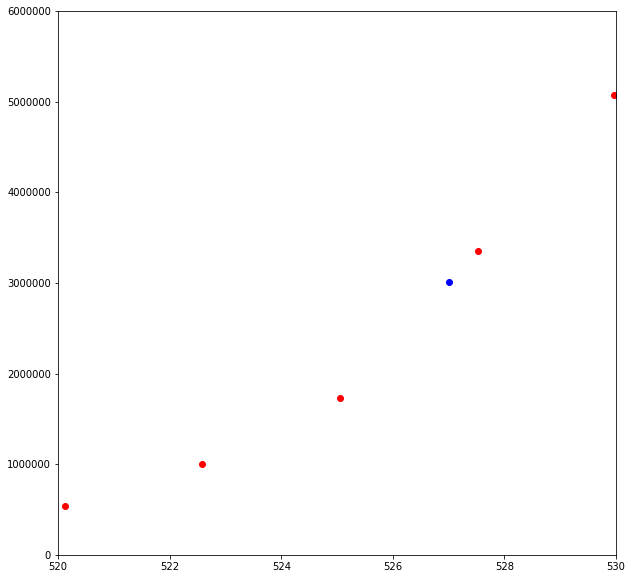

In [247]:
import pylab as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.plot(boxes[1].roi.rt_list,boxes[1].roi.intensity_list,'ro')
plt.xlim([520,530])
plt.plot(527,get_intensity(boxes[1].roi,527),'bo')
plt.ylim([0,6e6])

In [248]:
import bisect


In [253]:
count = 0
total = 0
no_roi = 0
for level,precursor,time,box_id,_ in schedule:
    if level == 'MS2' and precursor > -1:
        total +=1
        box = box_dict[box_id]
        if not box.roi is None:
            intensity = get_intensity(box.roi,time)
            if intensity >= 5e3:
                count += 1
        else:
            no_roi += 1
print(count,total,no_roi)

2144 4324 27
